#### Imports

In [1]:
! pip install tensorflow keras --quiet
! pip install seaborn --quiet
! pip install pyyaml h5py --quiet  # Required to save models in HDF5 format

In [2]:
# dataset
import shutil
import os

import pandas as pd
import collections

# model
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.applications import MobileNetV2

import keras_tuner as kt
# from keras_cv.layers import AugMix

# graphs/stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

2025-05-22 07:21:39.224488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747898499.257130   24151 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747898499.267805   24151 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747898499.291564   24151 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747898499.291600   24151 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747898499.291603   24151 computation_placer.cc:177] computation placer alr

#### Dataset loading and preprocessing

In [3]:
# dataset folder
directory = "./cell_images"

filepath = []
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)

# Concatenate data paths with labels
file_path_series = pd.Series(filepath, name='filepath')
Label_path_series = pd.Series(label, name='label')
df_train = pd.concat([file_path_series, Label_path_series], axis=1)

In [4]:
# splitting the dataset and getting class names
img_height = 128
img_width = 128
batch_size = 32
SEED = 123 # for reproducibility

# training, test set split
# resizing already handled by TensorFlow
# no need to reshape

print('Loading and splitting the tf_dataset')
train_set, test_set = keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,  # 80/20%
  subset="both",
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='binary'    # parasitized/uninfected
)
print("Actually the last one is the test set (issue of keras.utils function)")

Loading and splitting the tf_dataset
Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Using 5511 files for validation.


2025-05-22 07:23:37.536139: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Actually the last one is the test set (issue of keras.utils function)


In [5]:
train_set = train_set.map(lambda x, y: (x/255, y))
test_set = test_set.map(lambda x, y: (x/255, y))

test_set = test_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#### Statistics computation

we start by loading both models from the saved files

In [21]:
# load both models
lightCNN = keras.saving.load_model('./saved_model/malaria_det.keras')
baseline = keras.saving.load_model('./saved_model/malaria_mobile_net.keras')

##### Model evaluation

In [22]:
def evaluate_model(model, test_set):
    y_true, y_probs = [], []

    for x_batch, y_batch in test_set:
        preds = model.predict(x_batch, verbose=0).ravel()
        y_probs.extend(preds)
        y_true.extend(y_batch.numpy())

    y_true = np.array(y_true)
    y_probs = np.array(y_probs)
    y_pred = (y_probs > 0.5).astype(int) # if more than 0.5 classify it as 1

    return y_true, y_probs, y_pred

In [23]:
# Evaluate both models
y_true_1, y_probs_1, y_pred_1 = evaluate_model(lightCNN, test_set)
y_true_2, y_probs_2, y_pred_2 = evaluate_model(baseline, test_set)

# Create output directory
output_dir = "statistics"
os.makedirs(output_dir, exist_ok=True)

2025-05-22 07:59:40.854982: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


##### Classification reports

In [24]:
# Print reports
print("LightCNN Classification Report")
print(classification_report(y_true_1, y_pred_1, target_names=['Uninfected', 'Parasitized']))
print(f"LightCNN AUC-ROC: {roc_auc_score(y_true_1, y_probs_1):.4f}\n")

print("Baseline Classification Report")
print(classification_report(y_true_2, y_pred_2, target_names=['Uninfected', 'Parasitized']))
print(f"Baseline AUC-ROC: {roc_auc_score(y_true_2, y_probs_2):.4f}\n")

LightCNN Classification Report
              precision    recall  f1-score   support

  Uninfected       0.98      0.94      0.96      2709
 Parasitized       0.94      0.98      0.96      2802

    accuracy                           0.96      5511
   macro avg       0.96      0.96      0.96      5511
weighted avg       0.96      0.96      0.96      5511

LightCNN AUC-ROC: 0.9907

Baseline Classification Report
              precision    recall  f1-score   support

  Uninfected       0.97      0.96      0.97      2709
 Parasitized       0.96      0.98      0.97      2802

    accuracy                           0.97      5511
   macro avg       0.97      0.97      0.97      5511
weighted avg       0.97      0.97      0.97      5511

Baseline AUC-ROC: 0.9925



##### ROC curves

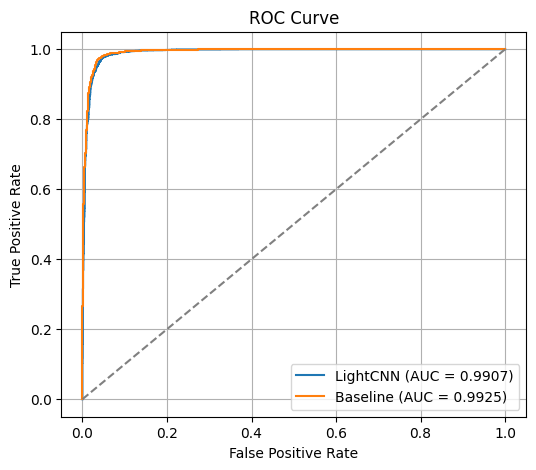

In [25]:
fpr1, tpr1, _ = roc_curve(y_true_1, y_probs_1)
fpr2, tpr2, _ = roc_curve(y_true_2, y_probs_2)

plt.figure(figsize=(6, 5))
plt.plot(fpr1, tpr1, label=f"LightCNN (AUC = {roc_auc_score(y_true_1, y_probs_1):.4f})")
plt.plot(fpr2, tpr2, label=f"Baseline (AUC = {roc_auc_score(y_true_2, y_probs_2):.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
roc_path = os.path.join(output_dir, "roc_curve_models.pdf")
plt.savefig(roc_path)
plt.show()

##### Precision/Recall curves

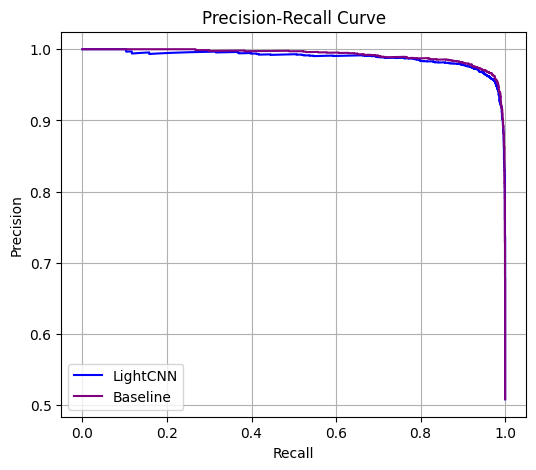

In [26]:
precision1, recall1, _ = precision_recall_curve(y_true_1, y_probs_1)
precision2, recall2, _ = precision_recall_curve(y_true_2, y_probs_2)

plt.figure(figsize=(6, 5))
plt.plot(recall1, precision1, label="LightCNN", color='blue')
plt.plot(recall2, precision2, label="Baseline", color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
prc_path = os.path.join(output_dir, "precision_recall_curve_models.pdf")
plt.savefig(prc_path)
plt.show()

##### Confusion matrices

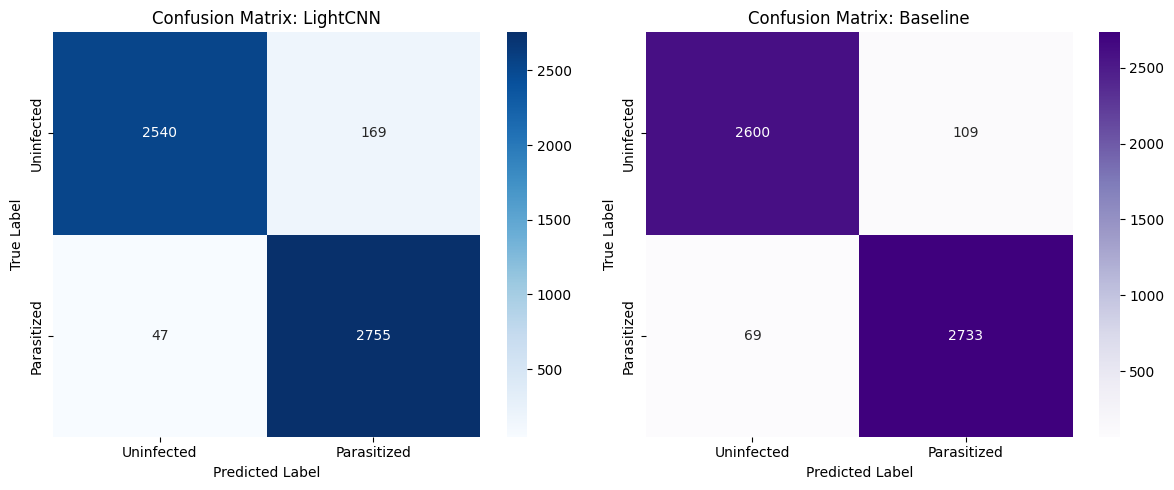

In [27]:
cm1 = confusion_matrix(y_true_1, y_pred_1)
cm2 = confusion_matrix(y_true_2, y_pred_2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
axes[0].set_title('Confusion Matrix: LightCNN')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Purples', ax=axes[1],
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
axes[1].set_title('Confusion Matrix: Baseline')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
confusion_path = os.path.join(output_dir, "confusion_matrices_models.pdf")
plt.savefig(confusion_path)
plt.show()